# OSMnxの概要デモ

OSMnxは、空間ジオメトリをダウンロードし、OpenStreetMapのAPIからストリートネットワークを構築、投影、視覚化できるPythonライブラリ

In [1]:
import geopandas as gpd
import osmnx as ox
%matplotlib inline
ox.config(log_console=True, use_cache=True)
ox.__version__

'0.11.4'

# OpenStreetMapからshapefilesを取得する

OSMnxでは、OpenStreetMapから空間の「場所の境界」ジオメトリをダウンロードできる。  
それらをshapefilesに保存し、投影し、プロットする。

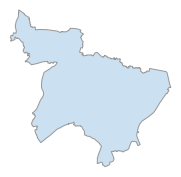

In [5]:
# 新宿区の境界ポリゴンを取得し、shapefilesとして保存し、UTMに投影して、プロット

import sys,os,os.path
os.environ['HTTP_PROXY']="10.156.1.120:80"
os.environ['HTTPS_PROXY']="10.156.1.120:80"

place = {'city' : 'shinjuku',
         'state' : 'Tokyo',
         'country' : 'Japan'}

city = ox.gdf_from_place(place)
ox.save_gdf_shapefile(city)
city = ox.project_gdf(city)
fig, ax = ox.plot_shape(city, figsize=(3,3))

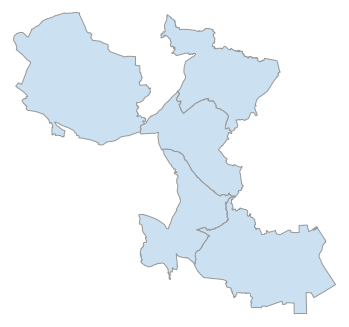

In [8]:
# 複数の都市の境界ポリゴンを取得し、shapefilesとして保存し、UTMに投影し、プロット
place_names = ['shinjuku, Tokyo, Japan', 
               'shibuya, Tokyo, Japan',
               'shinagawa, Tokyo, Japan',
               'meguro, Tokyo, Japan',
               'suginami, Tokyo, japan']
east_bay = ox.gdf_from_places(place_names)
ox.save_gdf_shapefile(east_bay)
east_bay = ox.project_gdf(east_bay)
fig, ax = ox.plot_shape(east_bay)

# 街路網をダウンロードして構築する

OSMnxを使用すると、ストリートネットワークデータをダウンロードしストリートネットワークを構築し、ネットワークを投影およびプロットし、ストリートネットワークを後で使用するためにSVG、GraphMLファイル、またはシェープファイルとして保存できます。

次のいずれかをOSMnxに提供することにより、ストリートネットワークをダウンロードできます

- 境界ボックス( bounding box)
- 緯度経度のポイントと距離
- 住所と距離
- 地名または地名のリスト
- 目的の道路網の境界のポリゴン

以下のような様々なネットワークタイプを指定することができる。

- drive：運転可能な公道を取得（ただし、サービス道路は取得できません）
- drive_service：サービス道路を含む運転可能な道路を取得
- walk: 歩行者が使用できるすべての道路とパスを取得（このネットワークタイプは一方向の方向性を無視します）
- bike: サイクリストが使用できるすべての道路と小道を取得
- all: すべての非プライベートOSMストリートおよびパスをダウンロード(Default)
- all_private: プライベートアクセスを含むすべてのOSMストリートとパスをダウンロード




界ボックス内のすべてのOSMノードとウェイからネットワークが構築される。

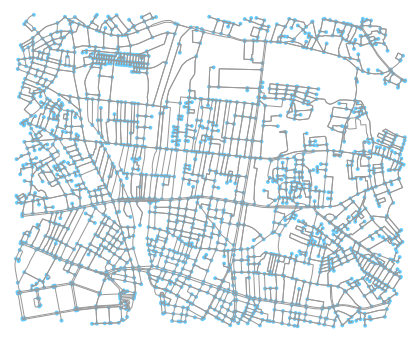

In [15]:
# 新宿区近辺で境界ボックスを定義する
# north, southは経度、 east, westは経度を指定する。
north, south, east, west = 35.71, 35.69,139.72,139.69

# 境界ボックスからネットワークを作成
G1 = ox.graph_from_bbox(north, south, east, west, network_type='drive_service')
G1 = ox.project_graph(G1)
fig, ax = ox.plot_graph(G1)

### 緯度経度のポイントと境界ボックスの距離をメートル単位で渡す

これにより、ポイントの北、南、東、西のnメートルの境界ボックスが作成され、その境界ボックス内のすべてのOSMノードとウェイからネットワークが構築される。

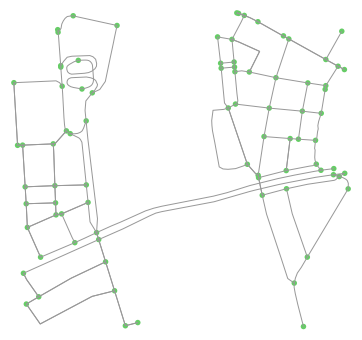

In [19]:
# グラフを構築する周囲の（緯度、経度）中心点を定義(個々では新宿駅の座標を指定)

location_point = (35.689607, 139.700571)

# 新宿駅から３００メートル範囲内を描画。
G2 = ox.graph_from_point(location_point, distance=300, distance_type='bbox', network_type='drive')
G2 = ox.project_graph(G2)
fig, ax = ox.plot_graph(G2, node_size=30, node_color='#66cc66')

### lat、lon）ポイントとネットワーク距離をメートル単位で渡す
これにより、ポイントの北、南、東、西のnメートルの境界ボックスが作成され、その境界ボックス内のすべてのOSMノードとウェイからネットワークが構築されます。   

次に、ネットワークに沿ったポイントからnメートル以上離れたすべてのノードを削除して、ネットワークを整理します。

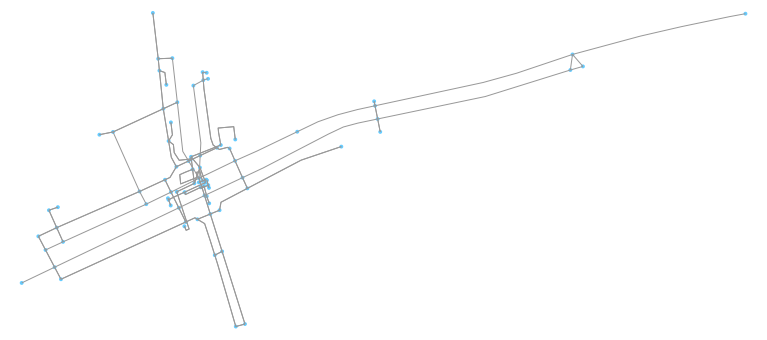

In [21]:
# ポイントからネットワークに沿って300m以内のノードのみのネットワークを作成
G3 = ox.graph_from_point(location_point, distance=300, distance_type='network')
fig, ax = ox.plot_graph(G3)

上記のプロットは、location_pointから300m（ネットワークに沿った移動距離）以内のネットワークを示しています。  
フォルトでは、network_typeパラメーター値は「all」です。これは、特定のタイプのトラフィックを制限するパスを除外しないことを意味します。  
これは、一方通行の通りが一方通行として表彰され、間違った方向に進むことができないことも意味します。  
したがって、300mは、許可された通りの方向にのみ移動している間に300m以内に到達できるノードのみを考慮します。
network_type = 'walk'を指定して、歩行が許可されているパスのみの道路ネットワークを構築できます。  
また、一方通行の通りの歩道をどちらの方向にも歩くことができるため、これにより、有向ネットワーク内のすべてのパスが双方向になります。  
したがって、300mでは、一方通行の道路であっても、どちらの方向に移動しても300m以内に到達できるノードが考慮されるようになりました。

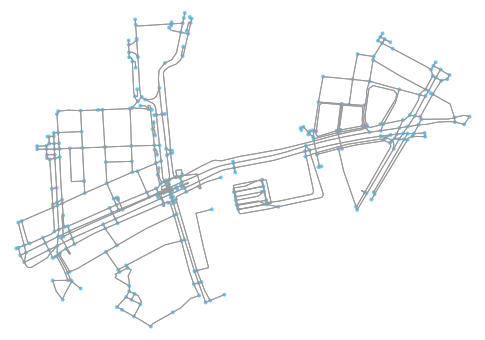

In [22]:
# ポイントからネットワークに沿って500m以内のノードのみのネットワークを作成する
G3 = ox.graph_from_point(location_point, distance=500, distance_type='network', network_type='walk')
G3 = ox.project_graph(G3)
fig, ax = ox.plot_graph(G3)

### メートル単位でアドレスと距離（境界ボックスまたはネットワーク）を渡す

これは住所をジオコーディングし、バウンディングボックスを作成し、ネットワークをダウンロードしてから、ネットワーク距離（distance_type = 'network'の場合）で整理します。

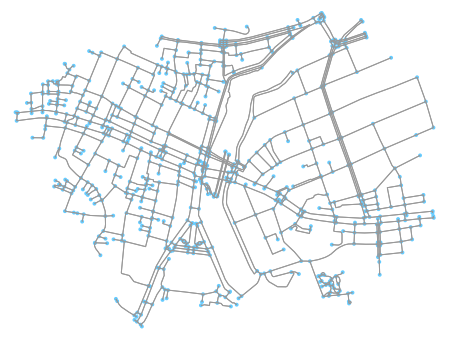

In [27]:
#新宿駅から徒歩１キロメートル範囲内を描画

G4 = ox.graph_from_address(address='3-38-1, Shinjuku, Shinjuku-ku, Tokyo', 
                              distance=1000, distance_type='network', network_type='walk')

# ネットワークをUTMに投影できます（ゾーンは自動的に計算されます）

G4_projected = ox.project_graph(G4)
fig, ax = ox.plot_graph(G4_projected)

### 地名を渡す

場所名をジオコーディングし、場所の境界形状ポリゴンと境界ボックスを取得し、境界ボックス内のネットワークをダウンロードしてから、場所の境界ポリゴンの外側にあるすべてのノードを整理する。

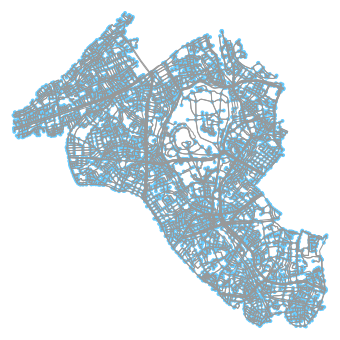

In [28]:
# 渋谷区の国境の都市内に道路網を作成する
G5 = ox.graph_from_place('shibuya, Tokyo, Japan')
G5_projected = ox.project_graph(G5)
fig, ax = ox.plot_graph(G5_projected)

複数の場所を渡すこともできる

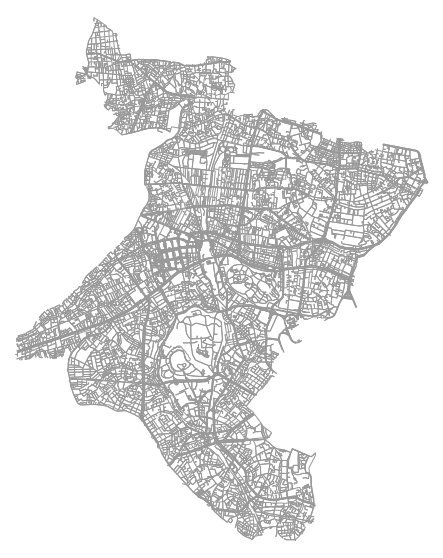

In [30]:
#新宿区と渋谷区を描画
places = ['shinjuku, Tokyo, Japan',
          'shibuya, Tokyo, Japan']
          
G5 = ox.graph_from_place(places, clean_periphery=False)
G5_projected = ox.project_graph(G5)
fig, ax = ox.plot_graph(G5_projected, fig_height=10, node_size=0)
ox.save_graph_shapefile(G5, filename='false')

### ストリートネットワークトポロジの簡素化

単純化は通常OSMnxによって自動的に行われますが、どのように動作するかを確認するためにそれを分解することができます。

OpenStreetMapノードは奇妙です。  
交差点は含まれますが、道路がカーブする単一のブロックに沿ったすべてのポイントも含まれます。  
後者はグラフ理論の意味でのノードではないため、アルゴリズム的にそれらを削除し、「真の」ネットワークノード間のエッジのセットを単一のエッジに統合します。
単純化モードには、strictとnon-strictの2つがあります。   

主な違いは、ストリクトモードとは異なり、非ストリクトモードでは「展開グラフ」の簡略化が可能になることです(

In [31]:
# まだ単純化しないある（緯度、経度）ポイントの周りにネットワークを作成する# 
# お台場周辺500メートルをプロット
location_point = (35.620583, 139.780545)
G = ox.graph_from_point(location_point, network_type='drive_service', distance=500, simplify=False)

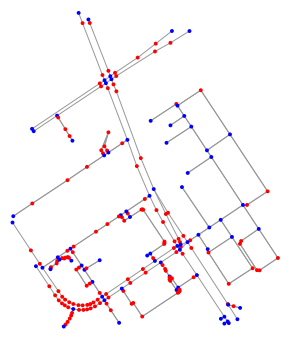

In [32]:
# strictモードをオフにして、削除するノードを赤で表示
nc = ['b' if ox.is_endpoint(G, node) else 'r' for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_zorder=3)

上記の赤と青のドットはOSMノードです。実際のネットワークノードではないため、赤のノードを削除します

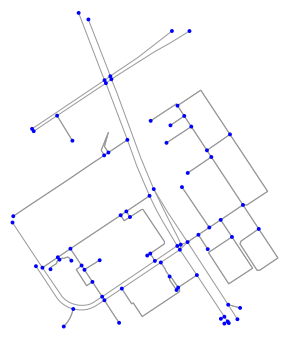

In [34]:
# simplify the network
G = ox.simplify_graph(G)
fig, ax = ox.plot_graph(G, node_color='b', node_zorder=3)

エッジの長さで色分けされたエッジを持つ単純化されたネットワークを表示

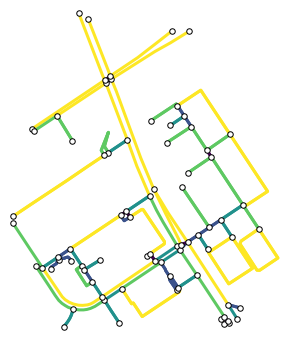

In [35]:
ec = ox.get_edge_colors_by_attr(G, attr='length')
fig, ax = ox.plot_graph(G, node_color='w', node_edgecolor='k', node_size=30, 
                           node_zorder=3, edge_color=ec, edge_linewidth=3)

平行なエッジをすべて紫色で強調表示します

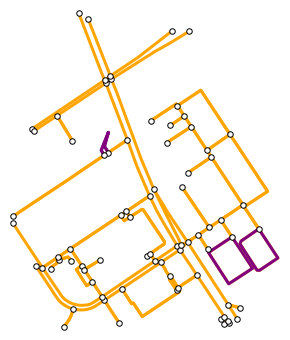

In [36]:
ec = ['orange' if key == 0 else 'purple' for u, v, key in G.edges(keys=True)]
fig, ax = ox.plot_graph(G, node_color='w', node_edgecolor='k', node_size=30, 
                           node_zorder=3, edge_color=ec, edge_linewidth=3)

以前のミッション地区ネットワークのすべての一方向のエッジを強調する

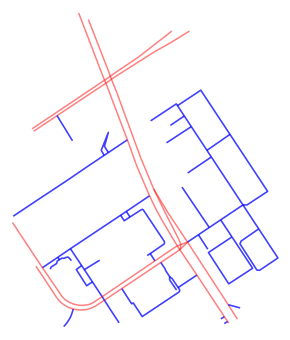

In [39]:
ec = ['r' if data['oneway'] else 'b' for u, v, key, data in G.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(G, node_size=0, edge_color=ec, edge_linewidth=1.5, edge_alpha=0.5)

### ネットワークをディスクに保存する

In [40]:
# GISで動作するように道路ネットワークをESRIシェープファイルとして保存する
ox.save_graph_shapefile(G, filename='network-shape')

In [41]:
# networkxまたはgephiで使用するGraphMLファイルとしてストリートネットワークを保存する
ox.save_graphml(G, filename='network.graphml')

In [42]:
# Adobe Illustratorで使用するために街路網をSVGとして保存
fig, ax = ox.plot_graph(G, show=False, save=True, filename='network', file_format='svg')

In [43]:
# 各ネットワークタイプの1つを取得し、イメージとシェープファイルとしてディスクに保存します
for nt in ['all_private', 'all', 'bike', 'walk', 'drive', 'drive_service']:
    G = ox.graph_from_address('N Sicily Pl, Chandler, AZ', network_type=nt, distance=1500)
    filename = 'az-{}'.format(nt)
    ox.save_graph_shapefile(G, filename=filename)
    fig, ax = ox.plot_graph(G, node_color='none', save=True, filename=filename, show=False)

In [44]:
# 基本的なネットワークメトリックを計算する
stats = ox.basic_stats(G)
stats['circuity_avg']


1.128158347382701

この道路網では、道路は直線の道よりも13％遠回りです